# create profile lines

In [1]:
import sys     

#path_to_pygplates = '/usr/lib/pygplates/revision18/'
path_to_pygplates = '/usr/local/lib/pygplates/revision28/'

#path_to_local_scripts = './scripts/'
path_to_local_scripts = '/home/dan/projects/shared_tools/'


sys.path.insert(1, path_to_pygplates)
sys.path.insert(1, path_to_local_scripts)

path_to_input_data = './input_data/'

In [2]:
%pylab inline


## Imports

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature


#geometry and mapping
import pygplates




#Libraries
  
import glob
import numpy as np
import math
import time
import pandas as pd
import pickle as pkl


#Filtering
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
from scipy.spatial import KDTree
from scipy import special


#earthquakes
import obspy
from obspy.imaging.beachball import beach
from obspy.imaging.beachball import beachball

#Locals
from tensor_tools import *
from geodesy import *
from utils import *
from rasters import *

Populating the interactive namespace from numpy and matplotlib


## parameters

In [3]:
#domain and profile lines setup

trench_north_limit= 41.8
trench_south_limit = 34.8
forearc_dist_km = 900         # (km) how far the profile lines extend landward from the trench
ocean_distance_fac = 0.6      # how far the profile goes toward the ocean, fraction of forearcDist
profile_spacing_km = 10.      # (km) use this to define a distance between the profiles lines
profile_inc_km = 1.           # (km) distance between points in each profile line



#filters/smoothing
gf_trench = 5
gf_azimuth = 20               #if lower value is used here, the profile lines will intersect



#set up some objects for convenience 

earth_radius_km = pygplates.Earth.mean_radius_in_kms
plot_extent = (133.0, 151.0, 30, 44.0)


land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])



## Load / parse data

In [4]:
#Trench shape file

_subzone = pygplates.FeatureCollection(path_to_input_data + 'tectonic_data/kuriles.shp')

#a quick hack to get the right bit of the shapefile
ic = 0
fs = []
for f in _subzone:
    if ic == 0:
        fs.append(f)
    ic += 1

        
    
_subzone = pygplates.FeatureCollection(fs[0])


subzone, trench_points = clean_trench_points(_subzone, gauss_filter_trench = gf_trench,
                                             north= trench_north_limit, 
                                             south=trench_south_limit, 
                                             profile_spacing_km=profile_spacing_km)

/home/dan/projects/shared_tools/utils.py:109: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  trench_points = np.row_stack((p for p in points_list))


In [5]:
#slab / bathymetry model

slab_path = path_to_input_data + 'japan_slab_model/PLMDL_2016/PAC_Plate/pac_base/pac_2017_3a.grd'

slab_data_dict = preprocess_grd_file(slab_path, zvar= 'z')

masked_slab_array =np.full_like(slab_data_dict['filled_array'], fill_value=np.nan)
masked_slab_array[slab_data_dict['mask_array'].astype('bool')] = slab_data_dict['filled_array'][slab_data_dict['mask_array'].astype('bool')]
masked_slab_array = -1.*masked_slab_array.data.copy()

## get the azimuths of the trench

In [6]:
trench_azimuths, trench_points = get_trench_azimuths(trench_points, plate_vel_azimuths=None)

trench_azimuths = gaussian_filter(trench_azimuths, gf_azimuth)

# define trench normal 
trench_normal_azimuths = trench_azimuths  + 90.

#also define trench_normal CCW from 3 o'clock, for plotting on maps
trig_trench_normal_azimuths = 360. - (trench_normal_azimuths  - 90.)


In [7]:
#trench_points

## Create profile lines



In [8]:

slab_normal_pts, ocean_normal_pts, profile_lines_list, \
profile_distances_list = create_profile_lines(trench_points, 
                                              trench_normal_azimuths,
                                              forearc_dist_km, 
                                              ocean_distance_fac,
                                              profile_inc_km=profile_inc_km, 
                                              earth_radius=earth_radius_km)


#profile_lines_list is a list containing several pygplates.PolylineOnSphere
#useful to have access to the profile lines list as a list of numpy arrays
profile_lines_list_numpy = [pygplates.MultiPointOnSphere(l).to_lat_lon_array() for l in profile_lines_list]

#useful for plotting
profile_distance_mean = np.mean(profile_distances_list, axis = 0)


(92, 2)


In [9]:
#use the outer profile lines to define the bounding region
#we'll use this to filter the earthquake catalog

domain_polygon_points  = np.vstack(
                                   (ocean_normal_pts[1::],
                                    profile_lines_list_numpy[-1][1:-1], 
                                    slab_normal_pts[1:-1][::-1], 
                                    profile_lines_list_numpy[0][1:-1][::-1]))



domain_polygon = pygplates.PolygonOnSphere(pygplates.MultiPointOnSphere(domain_polygon_points
                                                                    ))

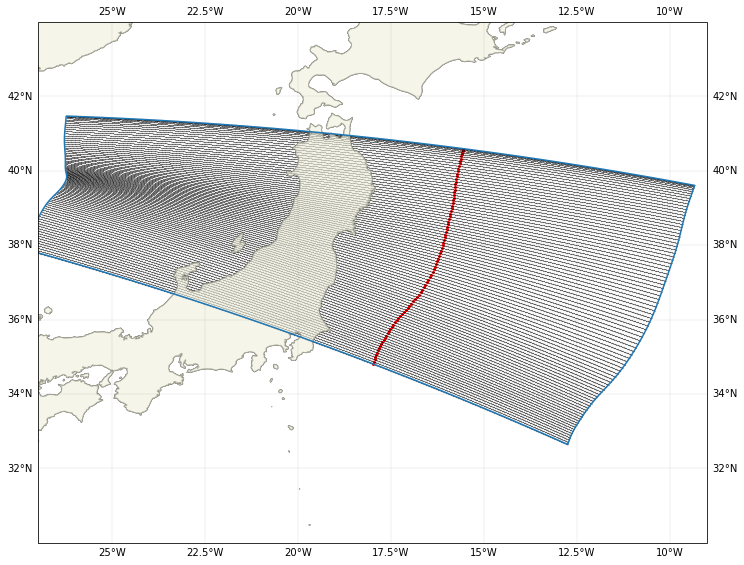

In [10]:
plt.figure(figsize=(12,12))


projection =ccrs.PlateCarree(central_longitude=160)


ax = plt.axes(projection=projection)

ax.set_extent(plot_extent,
              crs=ccrs.PlateCarree())




ax.scatter(trench_points[:,1], trench_points[:,0], 
        transform = ccrs.PlateCarree(), s = 4, c = 'r') 



gl = ax.gridlines(crs=projection, draw_labels=True,
                  linewidth=0.25, color='gray', alpha=0.5, linestyle='-')


ax.coastlines(resolution='10m')
ax.add_feature(land_10m, alpha=0.6)


ax.plot(domain_polygon.to_lat_lon_array()[:,1], 
        domain_polygon.to_lat_lon_array()[:,0], transform=ccrs.Geodetic()) 


for i in range(0,len(profile_lines_list))[::1]:
    ax.scatter(profile_lines_list[i].to_lat_lon_array()[:,1], profile_lines_list[i].to_lat_lon_array()[:,0], 
                        c = 'k', transform=ccrs.PlateCarree(), s=0.01)

    
    
#ax.quiver(
#trench_points[::10,1],
#trench_points[::10,0],
#np.cos(np.deg2rad(trig_trench_normal_azimuths))[::10], 
#np.sin(np.deg2rad(trig_trench_normal_azimuths))[::10],
#    transform=ccrs.PlateCarree(),
#                 scale=5,zorder=1,color='k',pivot='middle',
#                 width=.0055,headlength=4.)

#plt.show()

#ax.grid()

## Get slab surface / bathymetry data along profile lines


`interp_raster_at_points` uses a bilinear interpolation scheme that derives from scipy. The bilinear scheme is probably uneccessary and this section could be replaced with a simpler method to sample the raster at points.

In [11]:
profile_depths_list = []

for i in range(0, len(profile_lines_list)):
    
    
    #interpolate the slab data
    #slab_mask is true for the indexes of points that are outside the slab raster
    slab_vals, slab_mask = interp_raster_at_points(slab_data_dict,
                                              profile_lines_list_numpy[i], pygplates_order=True)

    #convert to + depth
    slab_vals*=-1
    

    

    #add to list
    profile_depths_list.append(slab_vals)

Text(0.5, 0, 'distance (km)')

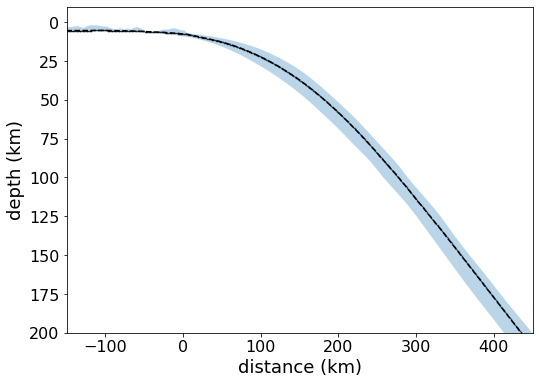

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))


ax.scatter(profile_distance_mean, np.nanmean(profile_depths_list, axis = 0) , c= 'k', s = 0.2)

ax.fill_between(profile_distance_mean, 
                np.amax(profile_depths_list, axis = 0), 
               np.amin(profile_depths_list, axis = 0), 
               alpha = 0.3)

ax.plot(profile_distance_mean, 
        np.nanmean(profile_depths_list, axis = 0) , c= 'k', ls = '--')



    
ax.set_ylim(200, -10)
ax.set_xlim(-150, 450)

ax.set_aspect(2)

ax.tick_params(labelsize=16)
ax.set_ylabel('depth (km)', size = 18)
ax.set_xlabel('distance (km)', size = 18)


## Save objects for use in 'slab_seismicity.ipynb'

In [14]:

save = True

if save:
    with open('./output_data/profile_lines_list.pkl','wb') as f:
        pkl.dump(profile_lines_list_numpy, f)
    with open('./output_data/profile_distances_list.pkl','wb') as f:
        pkl.dump(profile_distances_list, f)
    with open('./output_data/trench_points.pkl','wb') as f:
        pkl.dump(trench_points, f)
    with open('./output_data/trench_azimuths.pkl','wb') as f:
        pkl.dump(trench_azimuths, f)
    with open('./output_data/profile_depths_list.pkl','wb') as f:
            pkl.dump(profile_depths_list, f)
    with open('./output_data/domain_polygon_points.pkl','wb') as f:
            pkl.dump(domain_polygon_points, f)

        